# MO413 - Ciência e Visualização de Dados em Saúde

## IC UNICAMP

## Análise de Neutropenia

### 1S2013

#### Maurício Pereira Lopes - RA 225242
---

In [1]:
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import f1_score

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import warnings
warnings.filterwarnings('ignore')

In [350]:
df_admissions = pd.read_csv("./data/neutropenia_min/neutro_admissions.csv")
df_diagnoses = pd.read_csv("./data/neutropenia_min/neutro_diagnoses.csv")
df_itemid_loinc = pd.read_csv("./data/neutropenia_min/neutro_itemid_loinc.csv")
df_labevents = pd.read_csv("./data/neutropenia_min/neutro_labevents_min.csv")

In [351]:
# adicionar a informação de casos em que havia diagnóstico de câncer
df_admis = df_admissions.copy()
pattern = "malignant.*neoplasm"
mask = df_diagnoses["long_title"].str.contains(pattern, case = False, na = False)
df_admis["cancer"] = df_admis["hadm_id"].isin(df_diagnoses[mask].hadm_id).astype(int)

# adicionar coluna com contagem de dias de internação para cada admissão
df_admis["dischtime"] = pd.to_datetime(df_admis["dischtime"])
df_admis["admittime"] = pd.to_datetime(df_admis["admittime"])
days_in = df_admis["dischtime"] - df_admis["admittime"]
df_admis["days_in"] = days_in.astype('timedelta64[D]')

# adicionar coluna indicando o desfecho de morte
df_admis["death"] = df_admis.deathtime != "\\N"
df_admis["death"] = df_admis["death"].astype(int)

In [352]:
df_admis

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,marital_status,race,cancer,days_in,death
0,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,0,2.0,0
1,10006431,28771670,2128-03-23 17:06:00,2128-03-30 15:00:00,\N,EW EMER.,MARRIED,WHITE,1,6.0,0
2,10010231,20687038,2118-03-07 17:27:00,2118-03-09 14:05:00,\N,OBSERVATION ADMIT,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,1.0,0
3,10010231,23083980,2118-01-31 17:58:00,2118-02-07 11:30:00,\N,OBSERVATION ADMIT,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,6.0,0
4,10010231,25499227,2117-11-08 20:21:00,2117-12-05 19:40:00,\N,EW EMER.,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4244,19992875,22729360,2161-05-09 23:30:00,2161-05-16 13:30:00,\N,EW EMER.,DIVORCED,WHITE,1,6.0,0
4245,19992875,22872788,2161-12-23 15:27:00,2161-12-25 17:45:00,\N,URGENT,DIVORCED,WHITE,0,2.0,0
4246,19994730,25836955,2169-04-17 21:33:00,2169-04-21 14:20:00,\N,EW EMER.,MARRIED,WHITE,0,3.0,0
4247,19995127,29614352,2138-03-30 13:37:00,2138-04-05 16:31:00,\N,EW EMER.,MARRIED,BLACK/AFRICAN AMERICAN,1,6.0,0


In [322]:
# ajustar os tipos das colunas
#df_admis['subject_id'] = df_admis.subject_id.astype(str)
#df_admis['hadm_id'] = df_admis.hadm_id.astype(str)
#df_admis['admission_type'] = df_admis.admission_type.astype('category')
#df_admis['marital_status'] = df_admis.marital_status.astype('category')
#df_admis['race'] = df_admis.race.astype('category')
#df_admis['cancer'] = df_admis.cancer.astype('category')
#df_admis['days_in'] = df_admis.days_in.astype('category')
#df_admis['death'] = df_admis.death.astype('category')

---
### Análise descritiva

In [323]:
# quantidade de admissões
df_admis.shape[0]

4249

In [324]:
# quantidade de pacientes
df_admis['subject_id'].unique().shape[0]

2691

In [325]:
# quantidade de raças pertencentes aos dados
df_admis['race'].unique().shape[0]

33

In [327]:
# número de mortes
df_admis['death'].astype(int).sum()

292

In [328]:
# quantidade de pacientes com diagnóstico de câncer
df_admis['cancer'].astype(int).sum()


1492

In [329]:
# quantidade de mortes de pacientes com câncer
df_groupedby_death = df_admis.groupby(['cancer', 'death'])['cancer'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)
df_groupedby_death

,cancer,death,count
0,0,0,2564
2,1,0,1393
1,0,1,193
3,1,1,99


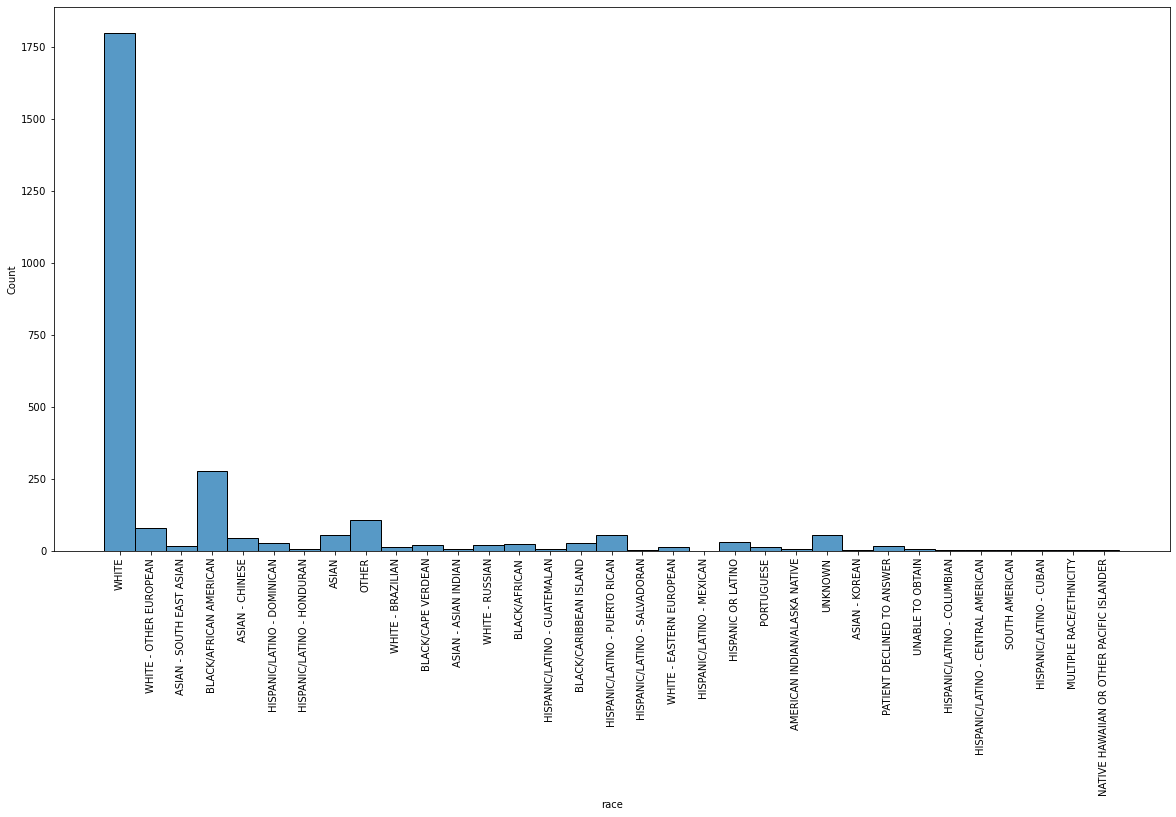

WHITE                                        1797
BLACK/AFRICAN AMERICAN                        277
OTHER                                         107
WHITE - OTHER EUROPEAN                         79
HISPANIC/LATINO - PUERTO RICAN                 56
UNKNOWN                                        55
ASIAN                                          54
ASIAN - CHINESE                                46
HISPANIC OR LATINO                             30
BLACK/CARIBBEAN ISLAND                         27
HISPANIC/LATINO - DOMINICAN                    26
BLACK/AFRICAN                                  23
WHITE - RUSSIAN                                20
BLACK/CAPE VERDEAN                             19
PATIENT DECLINED TO ANSWER                     17
ASIAN - SOUTH EAST ASIAN                       15
WHITE - EASTERN EUROPEAN                       12
WHITE - BRAZILIAN                              12
PORTUGUESE                                     12
UNABLE TO OBTAIN                                7


In [141]:
# quantidade de pacientes por raça
df_groupedby_subject_id = df_admis.groupby(['subject_id', 'race'])['race'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)

fig, ax = plt.subplots(figsize = (20, 10))
sns.histplot(df_groupedby_subject_id['race'])
plt.xticks(rotation = 90)
plt.show()

print(df_groupedby_subject_id['race'].value_counts())
print("Total:", df_groupedby_subject_id['race'].value_counts().sum())

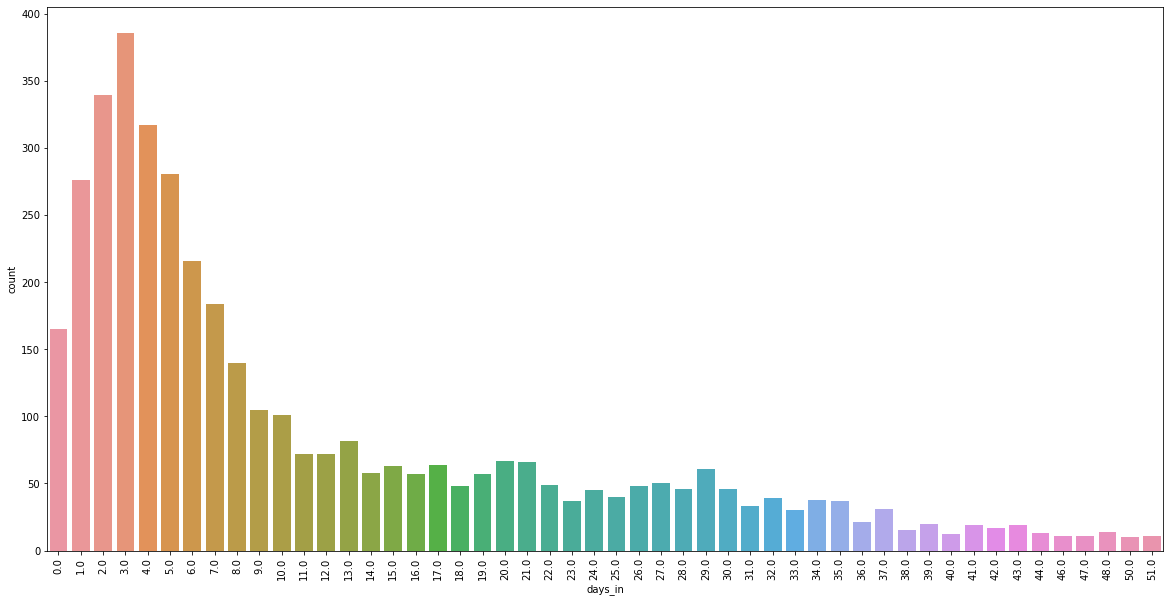

,days_in,count
3,3.0,386
2,2.0,340
4,4.0,317
5,5.0,281
1,1.0,276
...,...,...
94,100.0,1
93,99.0,1
89,93.0,1
85,89.0,1


In [237]:
# quantidade de dias de internação por admissão
df_groupedby_days = df_admis.groupby(['days_in'])['days_in'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)

fig, ax = plt.subplots(figsize = (20, 10))
df_temp = df_groupedby_days.iloc[:50, :]
sns.barplot(data = df_temp, x = df_temp['days_in'], y = df_temp['count'])
plt.xticks(rotation = 90)
plt.show()


df_groupedby_days

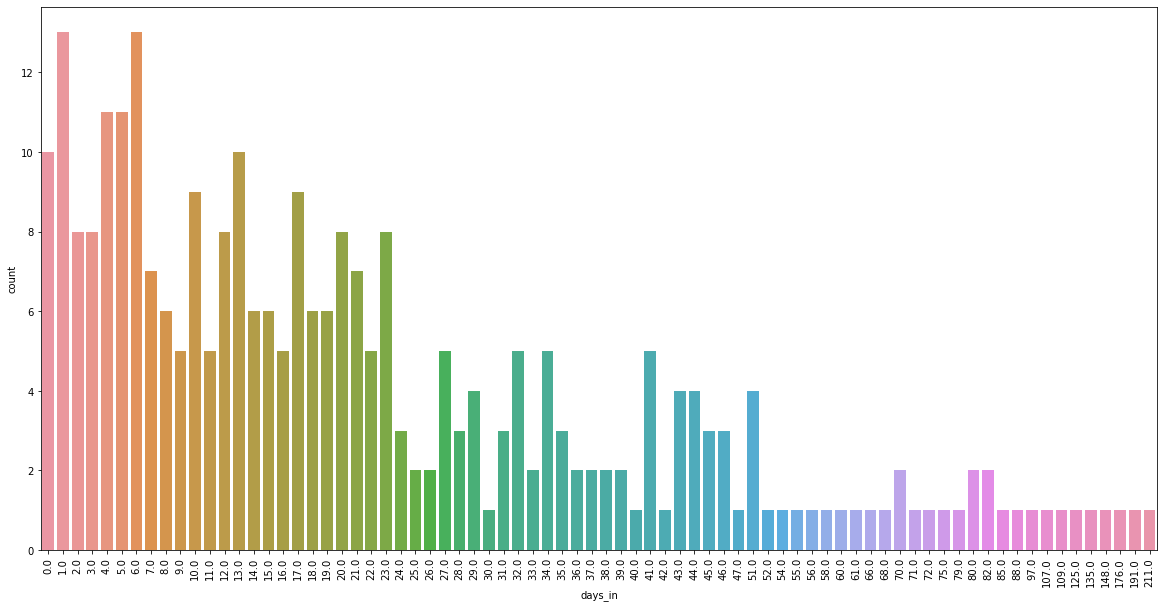

,days_in,count
1,1.0,13
6,6.0,13
4,4.0,11
5,5.0,11
0,0.0,10
...,...,...
51,55.0,1
50,54.0,1
49,52.0,1
47,47.0,1


In [246]:
# quantidades de dias de internação para admissões com desfecho de morte
df_death = df_admis[df_admis['death'] == 1]

df_groupedby_days_death = df_death.groupby(['days_in'])['days_in'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)

fig, ax = plt.subplots(figsize = (20, 10))
df_temp = df_groupedby_days_death
sns.barplot(data = df_temp, x = df_temp['days_in'], y = df_temp['count'])
plt.xticks(rotation = 90)
plt.show()


df_groupedby_days_death

In [241]:
# quantidade de admissões por tipo
df_groupedby_admis_type = df_admis.groupby(['admission_type'])['admission_type'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)

df_groupedby_admis_type

,admission_type,count
5,EW EMER.,1456
6,OBSERVATION ADMIT,1158
1,DIRECT EMER.,733
3,ELECTIVE,353
8,URGENT,297
4,EU OBSERVATION,141
2,DIRECT OBSERVATION,83
7,SURGICAL SAME DAY ADMISSION,19
0,AMBULATORY OBSERVATION,9


In [247]:
# quantidade de admissões por tipo para casos onde houve morte
df_groupedby_admis_type_death = df_death.groupby(['admission_type'])['admission_type'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)

df_groupedby_admis_type_death

,admission_type,count
2,EW EMER.,110
3,OBSERVATION ADMIT,84
0,DIRECT EMER.,56
5,URGENT,28
1,ELECTIVE,13
4,SURGICAL SAME DAY ADMISSION,1


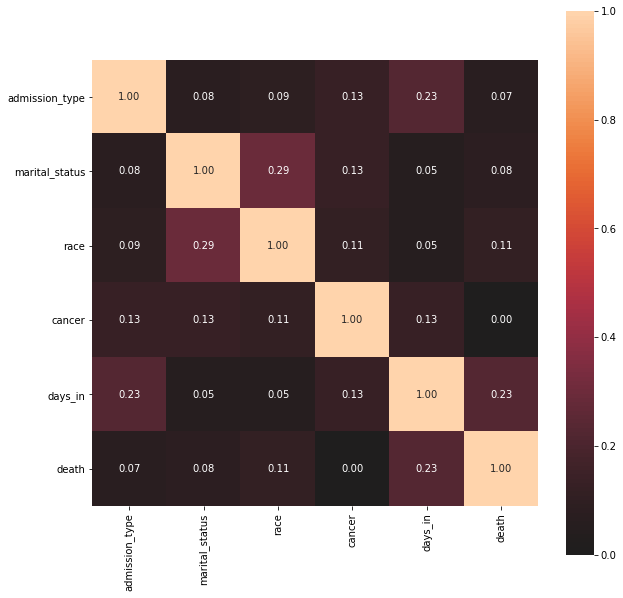

In [347]:
# correlações entre as variáveis básicas do problema
complete_correlation = associations(df_admis.iloc[:, 5:11], figsize=(10,10))


In [354]:
# Fazer o join das tabelas df_admissions e df_diagnosis
df_deaths_diagnosis = pd.merge(df_admis, df_diagnoses)

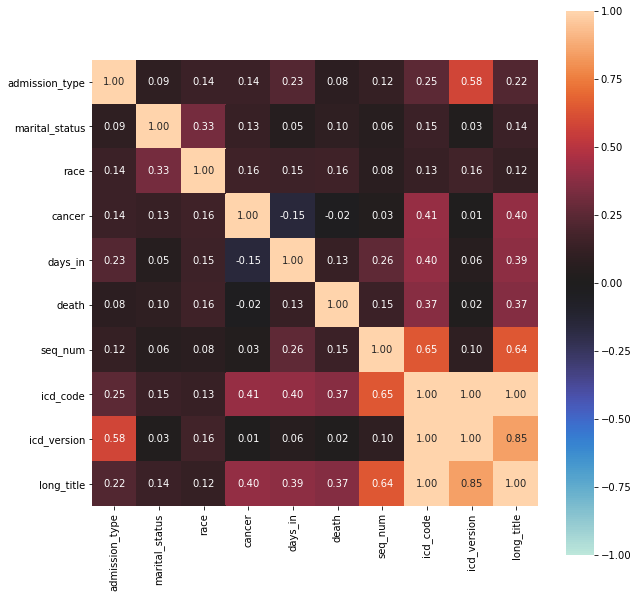

In [357]:
# correlações entre as variáveis de admissão e de diagnósticos
complete_correlation = associations(df_deaths_diagnosis.iloc[:, 5:], figsize=(10,10))

In [356]:
df_deaths_diagnosis.iloc[:, 5:]

,admission_type,marital_status,race,cancer,days_in,death,seq_num,icd_code,icd_version,long_title
0,EW EMER.,MARRIED,WHITE,0,2.0,0,1,28800,9,"Neutropenia, unspecified"
1,EW EMER.,MARRIED,WHITE,0,2.0,0,2,20190,9,"Hodgkin's disease, unspecified type, unspecifi..."
2,EW EMER.,MARRIED,WHITE,0,2.0,0,3,2853,9,Antineoplastic chemotherapy induced anemia
3,EW EMER.,MARRIED,WHITE,0,2.0,0,4,78061,9,Fever presenting with conditions classified el...
4,EW EMER.,MARRIED,WHITE,0,2.0,0,5,E9331,9,Antineoplastic and immunosuppressive drugs cau...
...,...,...,...,...,...,...,...,...,...,...
74479,EW EMER.,MARRIED,WHITE,1,9.0,0,9,2859,9,"Anemia, unspecified"
74480,EW EMER.,MARRIED,WHITE,1,9.0,0,10,71941,9,"Pain in joint, shoulder region"
74481,EW EMER.,MARRIED,WHITE,1,9.0,0,11,33829,9,Other chronic pain
74482,EW EMER.,MARRIED,WHITE,1,9.0,0,12,78052,9,"Insomnia, unspecified"


In [340]:
# random forest para predizer desfecho de morte na tabela df_admis

# separar X e y
X = df_admis.iloc[:, 5:10]
X = pd.get_dummies(X, columns = ["admission_type", "marital_status", "race"])
X = X.to_numpy()
y = df_admis.iloc[:, 10].to_numpy()


# separação dos datasets de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

# gerar o modelo
rforest = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)

# predição
y_hat = rforest.predict(X_test)

# scores
print(rforest.score(X_test, y_test))
print("\n", confusion_matrix(y_test, y_hat))
print('\nF1 score', f1_score(y_test, y_hat))

0.8721568627450981

 [[1103   90]
 [  73    9]]

F1 score 0.09944751381215468


In [368]:
# random forest para predizer desfecho de morte na tabela df_deaths_diagnosis

# movendo a coluna death para o final do data frame
death = df_deaths_diagnosis['death']
df_deaths_diagnosis = df_deaths_diagnosis.drop(columns=['death'])
df_deaths_diagnosis['death'] = death

# separar X e y
X = df_deaths_diagnosis.iloc[:, 5:14]
X = pd.get_dummies(X, columns = ["admission_type", "marital_status", "race", "icd_code", "long_title"])
X = X.to_numpy()
y = df_deaths_diagnosis.iloc[:, 14].to_numpy()


# separação dos datasets de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

# gerar o modelo
rforest = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)

# predição
y_hat = rforest.predict(X_test)

# scores
print(rforest.score(X_test, y_test))
print("\n", confusion_matrix(y_test, y_hat))
print('\nF1 score', f1_score(y_test, y_hat))

0.9156001074017721

 [[19916   212]
 [ 1674   544]]

F1 score 0.36583725622057833


Accuracy: 0.9156001074017721


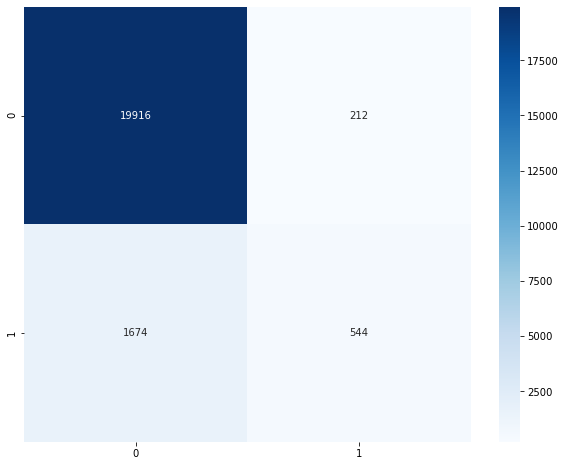


F1 score 0.36583725622057833


In [381]:
print("Accuracy:", rforest.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_hat)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, fmt = '0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_hat))

In [125]:
# associação entre admissões em emergência e desfecho de morte

# converter variável admission_type em dummy variables
admis_type = df_admis["admission_type"].unique().tolist()
pd.get_dummies(df_admis, columns = ["admission_type"])

,subject_id,hadm_id,admittime,dischtime,deathtime,marital_status,race,cancer,days_in,death,admission_type_AMBULATORY OBSERVATION,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT
0,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,MARRIED,WHITE,0,2.0,0,0,0,0,0,0,1,0,0,0
1,10006431,28771670,2128-03-23 17:06:00,2128-03-30 15:00:00,\N,MARRIED,WHITE,1,6.0,0,0,0,0,0,0,1,0,0,0
2,10010231,20687038,2118-03-07 17:27:00,2118-03-09 14:05:00,\N,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,1.0,0,0,0,0,0,0,0,1,0,0
3,10010231,23083980,2118-01-31 17:58:00,2118-02-07 11:30:00,\N,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,6.0,0,0,0,0,0,0,0,1,0,0
4,10010231,25499227,2117-11-08 20:21:00,2117-12-05 19:40:00,\N,SINGLE,HISPANIC/LATINO - GUATEMALAN,0,26.0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,19992875,22729360,2161-05-09 23:30:00,2161-05-16 13:30:00,\N,DIVORCED,WHITE,1,6.0,0,0,0,0,0,0,1,0,0,0
4245,19992875,22872788,2161-12-23 15:27:00,2161-12-25 17:45:00,\N,DIVORCED,WHITE,0,2.0,0,0,0,0,0,0,0,0,0,1
4246,19994730,25836955,2169-04-17 21:33:00,2169-04-21 14:20:00,\N,MARRIED,WHITE,0,3.0,0,0,0,0,0,0,1,0,0,0
4247,19995127,29614352,2138-03-30 13:37:00,2138-04-05 16:31:00,\N,MARRIED,BLACK/AFRICAN AMERICAN,1,6.0,0,0,0,0,0,0,1,0,0,0


In [123]:
df_admis["admission_type"].unique().tolist()

['EW EMER.',
 'OBSERVATION ADMIT',
 'ELECTIVE',
 'EU OBSERVATION',
 'DIRECT EMER.',
 'URGENT',
 'DIRECT OBSERVATION',
 'SURGICAL SAME DAY ADMISSION',
 'AMBULATORY OBSERVATION']

---
## Primeira análise
### Diagnósticos mais associados a mortes

Quais os disgnósticos mais frequentes nos casos de desfecho com morte?

In [271]:
# Fazer o join das tabelas df_admissions e df_diagnosis
df_deaths_diagnosis = pd.merge(df_admissions, df_diagnoses)

# filtrar somente os casos de morte
df_deaths_diags_filtered = df_deaths_diagnosis[df_deaths_diagnosis.deathtime != "\\N"]

In [272]:
# contar quantos foram os casos de morte para cada tipo de diagnóstico
df_groupedby_icd_code = df_deaths_diags_filtered.groupby(['icd_code', 'long_title'])['long_title'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)
df_groupedby_icd_code.head(20)

,icd_code,long_title,count
1708,Z66,Do not resuscitate,131
207,28800,"Neutropenia, unspecified",118
1705,Z515,Encounter for palliative care,113
1221,J9601,Acute respiratory failure with hypoxia,77
1504,R5081,Fever presenting with conditions classified el...,72
849,D709,"Neutropenia, unspecified",71
1418,N179,"Acute kidney failure, unspecified",69
1769,Z87891,Personal history of nicotine dependence,65
566,78061,Fever presenting with conditions classified el...,63
649,99592,Severe sepsis,60


Esta tabela lista as quantidades de casos de mortes para cada tipo de diagnóstico, porém não permite uma conclusão sobre a associação destas informações pois um mesmo paciente é contado várias vezes, pois há várias informações de diagnóstico para um mesmo paciente.

Este caminho não parece permitir uma boa análise.

---
Vou avaliar os exames que mais foram feitos nos pacientes que morreram.

In [348]:
df_deaths_diagnosis

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,marital_status,race,seq_num,icd_code,icd_version,long_title
0,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,1,28800,9,"Neutropenia, unspecified"
1,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,2,20190,9,"Hodgkin's disease, unspecified type, unspecifi..."
2,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,3,2853,9,Antineoplastic chemotherapy induced anemia
3,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,4,78061,9,Fever presenting with conditions classified el...
4,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE,5,E9331,9,Antineoplastic and immunosuppressive drugs cau...
...,...,...,...,...,...,...,...,...,...,...,...,...
74479,19998562,26846592,2166-04-06 20:38:00,2166-04-16 16:20:00,\N,EW EMER.,MARRIED,WHITE,9,2859,9,"Anemia, unspecified"
74480,19998562,26846592,2166-04-06 20:38:00,2166-04-16 16:20:00,\N,EW EMER.,MARRIED,WHITE,10,71941,9,"Pain in joint, shoulder region"
74481,19998562,26846592,2166-04-06 20:38:00,2166-04-16 16:20:00,\N,EW EMER.,MARRIED,WHITE,11,33829,9,Other chronic pain
74482,19998562,26846592,2166-04-06 20:38:00,2166-04-16 16:20:00,\N,EW EMER.,MARRIED,WHITE,12,78052,9,"Insomnia, unspecified"


In [273]:
# Fazer o join das tabelas df_admissions e df_diagnosis
df_deaths_labevents = pd.merge(df_admissions, df_labevents)

# filtrar somente os casos de morte
df_deaths_labevents_filtered = df_deaths_labevents[df_deaths_labevents.deathtime != "\\N"]

In [274]:
# contar os exames que mais foram feitos para os casos onde houve morte
df_groupedby_itemid = df_deaths_labevents_filtered.groupby(['itemid'])['itemid'] \
                        .count() \
                        .reset_index(name = 'count') \
                        .sort_values(['count'], ascending = False)
df_groupedby_itemid = pd.merge(df_itemid_loinc, df_groupedby_itemid).iloc[:, [0, 1, 8]] \
                                                                    .sort_values(['count'], ascending = False) 
df_groupedby_itemid.head(20)

,itemid,label,count
210,51265,Platelet Count,11994
138,50971,Potassium,10672
146,50983,Sodium,10606
99,50902,Chloride,10539
86,50882,Bicarbonate,10416
107,50912,Creatinine,10405
81,50868,Anion Gap,10398
156,51006,Urea Nitrogen,10347
119,50931,Glucose,10319
200,51221,Hematocrit,10249


Novamente há uma dificuldade na análise pelo fato de que um único caso de morte é contado várias vezes pelo fato de vários exames terem sido feitos para cada paciente.

Além disso, não há informação sobre o relacionamento entre os exames e os diagnósticos.

---
Vou tentar montar uma tabela com unindo as admissões, os diagnósticos e os exames.
Daí, então, vou tentar um classificador Random Forest para tentar predizer os desfechos de morte ou não-morte.


In [275]:
# Fazer o join das tabelas df_deaths_diagnosis e df_labevents
df_full_join = pd.merge(df_deaths_diagnosis, df_labevents)

In [277]:
# adicionar a informação de casos em que havia diagnóstico de câncer
df_admis = df_admissions.copy()
pattern = "malignant.*neoplasm"
mask = df_diagnoses["long_title"].str.contains(pattern, case = False, na = False)
df_full_join["cancer"] = df_full_join["hadm_id"].isin(df_diagnoses[mask].hadm_id).astype(int)

# adicionar coluna com contagem de dias de internação para cada admissão
df_full_join["dischtime"] = pd.to_datetime(df_full_join["dischtime"])
df_full_join["admittime"] = pd.to_datetime(df_full_join["admittime"])
days_in = df_full_join["dischtime"] - df_full_join["admittime"]
df_full_join["days_in"] = days_in.astype('timedelta64[D]')

# adicionar coluna indicando o desfecho de morte
df_full_join["death"] = df_full_join.deathtime != "\\N"
df_full_join["death"] = df_full_join["death"].astype(int)

In [28]:
df_admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,marital_status,race
0,10003019,25179393,2175-12-08 17:38:00,2175-12-11 17:20:00,\N,EW EMER.,MARRIED,WHITE
1,10006431,28771670,2128-03-23 17:06:00,2128-03-30 15:00:00,\N,EW EMER.,MARRIED,WHITE
2,10010231,20687038,2118-03-07 17:27:00,2118-03-09 14:05:00,\N,OBSERVATION ADMIT,SINGLE,HISPANIC/LATINO - GUATEMALAN
3,10010231,23083980,2118-01-31 17:58:00,2118-02-07 11:30:00,\N,OBSERVATION ADMIT,SINGLE,HISPANIC/LATINO - GUATEMALAN
4,10010231,25499227,2117-11-08 20:21:00,2117-12-05 19:40:00,\N,EW EMER.,SINGLE,HISPANIC/LATINO - GUATEMALAN
...,...,...,...,...,...,...,...,...
4244,19992875,22729360,2161-05-09 23:30:00,2161-05-16 13:30:00,\N,EW EMER.,DIVORCED,WHITE
4245,19992875,22872788,2161-12-23 15:27:00,2161-12-25 17:45:00,\N,URGENT,DIVORCED,WHITE
4246,19994730,25836955,2169-04-17 21:33:00,2169-04-21 14:20:00,\N,EW EMER.,MARRIED,WHITE
4247,19995127,29614352,2138-03-30 13:37:00,2138-04-05 16:31:00,\N,EW EMER.,MARRIED,BLACK/AFRICAN AMERICAN


In [33]:
df_diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,10003019,25179393,1,28800,9,"Neutropenia, unspecified"
1,10003019,25179393,2,20190,9,"Hodgkin's disease, unspecified type, unspecifi..."
2,10003019,25179393,3,2853,9,Antineoplastic chemotherapy induced anemia
3,10003019,25179393,4,78061,9,Fever presenting with conditions classified el...
4,10003019,25179393,5,E9331,9,Antineoplastic and immunosuppressive drugs cau...
...,...,...,...,...,...,...
74479,19998562,26846592,9,2859,9,"Anemia, unspecified"
74480,19998562,26846592,10,71941,9,"Pain in joint, shoulder region"
74481,19998562,26846592,11,33829,9,Other chronic pain
74482,19998562,26846592,12,78052,9,"Insomnia, unspecified"


In [30]:
df_itemid_loinc

,itemid,label,fluid,category,valueuom,loinc,loinc_version,notes
0,50856,Acetaminophen,Blood,Chemistry,ug/mL,NaN,2.71,\N
1,50867,Amylase,Blood,Chemistry,IU/L,NaN,2.71,\N
2,50873,Anti-Nuclear Antibody,Blood,Chemistry,NaN,NaN,2.71,\N
3,50874,"Anti-Nuclear Antibody, Titer",Blood,Chemistry,NaN,NaN,2.71,\N
4,50893,"Calcium, Total",Blood,Chemistry,mg/dL,NaN,2.71,\N
...,...,...,...,...,...,...,...,...
750,52358,NRBC#,Other Body Fluid,Hematology,\N,NaN,2.71,\N
751,52369,\N,Other Body Fluid,Hematology,\N,NaN,2.71,\N
752,52373,Blasts#,Pleural,Hematology,\N,NaN,2.71,\N
753,52391,FL1-S,Q,Hematology,\N,NaN,2.71,\N


In [31]:
df_labevents

,hadm_id,specimen_id,itemid,charttime,value,valuenum,valueuom
0,25179393,30599113,51200,2175-12-09 08:10:00,0,0,%
1,25179393,30599113,51250,2175-12-09 08:10:00,102,102,fL
2,25179393,75561856,51200,2175-12-10 08:00:00,0,0,%
3,25179393,75561856,51250,2175-12-10 08:00:00,105,105,fL
4,25179393,59548859,51200,2175-12-11 08:25:00,1,1,%
...,...,...,...,...,...,...,...
3626561,26846592,68072203,51249,2166-04-12 07:00:00,34.8,34.8,%
3626562,26846592,72555587,51249,2166-04-13 07:15:00,34.1,34.1,%
3626563,26846592,5125140,51249,2166-04-14 07:20:00,33.8,33.8,%
3626564,26846592,20300538,51249,2166-04-15 07:32:00,33.8,33.8,%


In [382]:
df = df_admissions.copy()

pattern = "malignant.*neoplasm"
mask = df_diagnoses["long_title"].str.contains(pattern, case = False, na = False)

In [383]:
df["cancer"] = df["hadm_id"].isin(df_diagnoses[mask].hadm_id).astype(int)

In [384]:
df_labevents['valuenum'] = pd.to_numeric(df_labevents['valuenum'], errors = 'coerce')

In [ ]:
df["death"] = df.deathtime != "\\N"
df["death"] = df["death"].astype(int)

In [ ]:
itemids = df_labevents["itemid"].unique().astype(str)
for v in itemids:
    df[v] = 0

In [ ]:
mask = df["hadm_id"].isin(df_labevents["hadm_id"])
new_df = df[mask]

j = 0
for i in list(range(new_df.shape[0])):
    if i < new_df.shape[0]:
        while(df_labevents.iloc[j]["hadm_id"] == new_df.iloc[i]["hadm_id"]):
            if mask[i] == True:
                itemid = df_labevents.loc[j, "itemid"].astype(str)
                if new_df.iloc[i][itemid] == 0:
                    new_df.loc[i, itemid] = df_labevents.loc[j, "valuenum"]
                j = j + 1
                if j >= df_labevents.shape[0]:
                    break
                if j % 300000 == 0:
                    print(j)
            else:
                j = j + 1
                if j >= df_labevents.shape[0]:
                    break
                if j % 300000 == 0:
                    print(j)                
    else:
        break

In [ ]:
new_df

In [ ]:
new_df.to_csv("./data/new_data.csv", index = False)

In [250]:
new_df = pd.read_csv("./data/new_data.csv")

In [251]:
new_df["dischtime"] = pd.to_datetime(new_df["dischtime"])
new_df["admittime"] = pd.to_datetime(new_df["admittime"])

In [252]:
days_in = new_df["dischtime"] - new_df["admittime"]
new_df["days_in"] = days_in.astype('timedelta64[D]')

In [385]:
new_df["admission_type"].unique()

array(['EW EMER.', 'OBSERVATION ADMIT', 'ELECTIVE', 'EU OBSERVATION',
       'DIRECT EMER.', 'URGENT', 'DIRECT OBSERVATION',
       'SURGICAL SAME DAY ADMISSION', 'AMBULATORY OBSERVATION'],
      dtype=object)

In [386]:
new_df["marital_status"].unique()

array(['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', '\\N'], dtype=object)

In [387]:
new_df["race"].unique()

array(['WHITE', 'HISPANIC/LATINO - GUATEMALAN', 'PORTUGUESE',
       'BLACK/AFRICAN AMERICAN', 'WHITE - OTHER EUROPEAN',
       'ASIAN - ASIAN INDIAN', 'OTHER', 'HISPANIC/LATINO - DOMINICAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - CHINESE',
       'WHITE - RUSSIAN', 'ASIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC OR LATINO',
       'SOUTH AMERICAN', 'WHITE - BRAZILIAN',
       'HISPANIC/LATINO - HONDURAN', 'PATIENT DECLINED TO ANSWER',
       'BLACK/CAPE VERDEAN', 'UNKNOWN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'BLACK/CARIBBEAN ISLAND',
       'WHITE - EASTERN EUROPEAN', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO - SALVADORAN', 'ASIAN - SOUTH EAST ASIAN',
       'HISPANIC/LATINO - CUBAN', 'MULTIPLE RACE/ETHNICITY',
       'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - COLUMBIAN',
       'HISPANIC/LATINO - MEXICAN'], dtype=object)

In [388]:
final_df = pd.get_dummies(new_df, columns = ["admission_type", "marital_status", "race"])

In [389]:
final_df = final_df.iloc[:, 5:].copy()

In [390]:
cols = final_df.columns.tolist()
cols.append(cols.pop(cols.index('cancer')))
cols.append(cols.pop(cols.index('days_in')))
cols.append(cols.pop(cols.index('death')))

In [391]:
final_df = final_df[cols]
final_df

,51200,51250,51251,51301,51252,50902,51254,50954,51255,51256,...,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,cancer,days_in,death
0,1.0,102.0,4.0,1.9,NaN,109.0,28.0,371.0,11.0,19.0,...,0,0,1,0,0,0,0,0,2.0,0
1,2.0,85.0,0.0,2.5,NaN,102.0,45.0,0.0,0.0,16.0,...,0,0,1,0,0,0,0,1,6.0,0
2,1.0,93.0,0.0,0.2,NaN,106.0,6.0,100.0,0.0,2.0,...,0,0,0,0,0,0,0,0,1.0,0
3,0.0,92.0,2.0,0.2,NaN,103.0,27.0,130.0,5.0,1.0,...,0,0,0,0,0,0,0,0,6.0,0
4,1.0,98.0,1.0,6.4,NaN,104.0,5.0,334.0,3.0,9.0,...,0,0,0,0,0,0,0,0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,6.0,0
4205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,2.0,0
4206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,3.0,0
4207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,6.0,0


In [392]:
final_df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 814 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   51200                                           4190 non-null   float64
 1   51250                                           4206 non-null   float64
 2   51251                                           4209 non-null   float64
 3   51301                                           4200 non-null   float64
 4   51252                                           714 non-null    float64
 5   50902                                           4209 non-null   float64
 6   51254                                           4191 non-null   float64
 7   50954                                           4209 non-null   float64
 8   51255                                           4209 non-null   float64
 9   51256                                   

In [393]:
# substituindo valores nulos por zero
final_df = final_df.fillna(0)

In [394]:
final_df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 814 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   51200                                           4209 non-null   float64
 1   51250                                           4209 non-null   float64
 2   51251                                           4209 non-null   float64
 3   51301                                           4209 non-null   float64
 4   51252                                           4209 non-null   float64
 5   50902                                           4209 non-null   float64
 6   51254                                           4209 non-null   float64
 7   50954                                           4209 non-null   float64
 8   51255                                           4209 non-null   float64
 9   51256                                   

In [265]:
final_df.describe()

,51200,51250,51251,51301,51252,50902,51254,50954,51255,51256,...,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,cancer,days_in,death
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.00000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,1.506296,90.220599,1.100832,6.199796,0.0,101.653124,10.890283,375.200998,0.875576,47.614041,...,0.001901,0.01378,0.678308,0.005940,0.004277,0.031124,0.006177,0.350677,15.215966,0.069138
std,3.089118,12.287756,2.195198,14.712301,0.0,12.884427,10.138744,5855.238756,1.993539,27.541279,...,0.043561,0.11659,0.467181,0.076849,0.065263,0.173673,0.078362,0.477239,19.555436,0.253718
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,87.000000,0.000000,1.800000,0.0,100.000000,4.000000,128.000000,0.000000,26.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,91.000000,0.000000,3.400000,0.0,103.000000,8.000000,204.000000,0.000000,51.000000,...,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000
75%,2.000000,95.000000,1.000000,6.500000,0.0,106.000000,15.000000,303.000000,1.000000,70.000000,...,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000
max,40.000000,133.000000,24.000000,513.700000,0.0,129.000000,87.000000,377000.000000,24.000000,100.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,230.000000,1.000000


In [408]:
final_df['death'].sum()

291

In [409]:
X = final_df.iloc[:, :812].to_numpy()
X = np.nan_to_num(X, nan = 0)
Y = final_df.iloc[:, 812:].to_numpy()
Y = np.nan_to_num(Y, nan = 0)

X_norm = normalize(X, axis = 1)
X_norm

array([[0.00184152, 0.18783478, 0.00736607, ..., 0.        , 0.        ,
        0.        ],
       [0.00591982, 0.25159226, 0.        , ..., 0.        , 0.        ,
        0.00295991],
       [0.00279536, 0.25996844, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ]])

---
Predição de desfecho entre morte ou não morte

In [411]:
# testar o balanceamento dos casos de desfecho de morte e não-morte
np.unique(Y[:, 1], return_counts = True)

(array([0., 1.]), array([3918,  291]))

In [412]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:, 1], test_size = 0.30, random_state = 42)

In [413]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)

In [400]:
clf.predict(X_test)

array([1., 1., 0., ..., 0., 0., 0.])

In [414]:
clf.score(X_test, y_test)

0.5843230403800475

0.5843230403800475


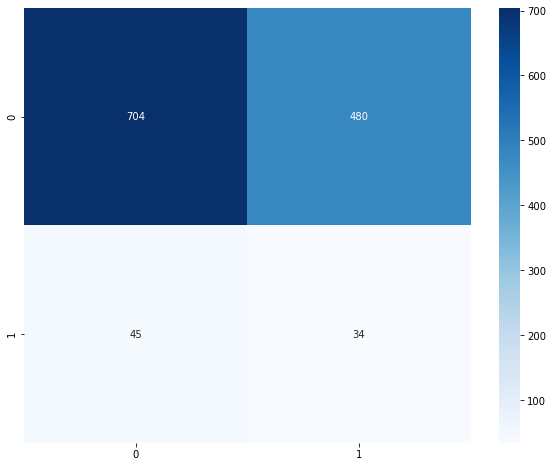


F1 score 0.11467116357504216


In [415]:
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

0.9374505146476643


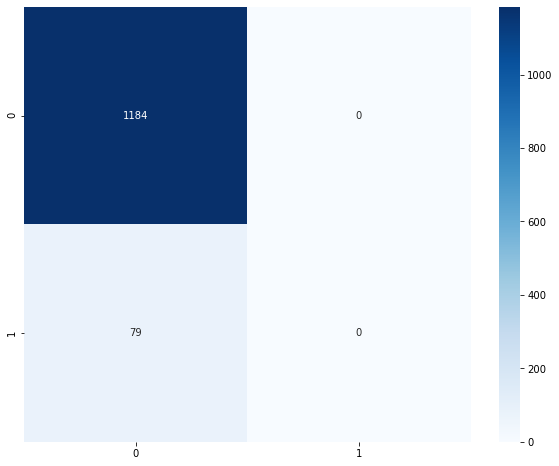


F1 score 0.0


In [416]:
clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

0.09422011084718923


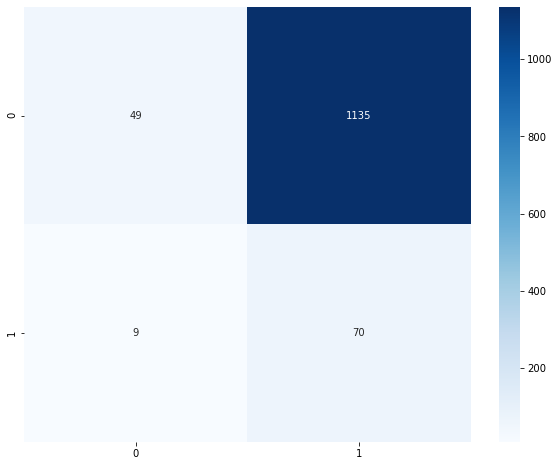


F1 score 0.1090342679127726


In [417]:
clf = svm.SVC(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

In [288]:
# pca
pca = PCA(n_components = 600)

In [289]:
pca.fit(X)

PCA(n_components=600)

In [290]:
pca.explained_variance_ratio_

array([4.63592914e-01, 2.54117994e-01, 9.59771746e-02, 4.92989616e-02,
       3.93883202e-02, 2.47806823e-02, 2.44864249e-02, 1.37278904e-02,
       1.28425338e-02, 7.04831873e-03, 5.92704684e-03, 3.02396202e-03,
       1.51967944e-03, 1.42602014e-03, 4.87044558e-04, 3.04250137e-04,
       2.35783041e-04, 2.30571346e-04, 2.03043397e-04, 1.36730046e-04,
       1.29859534e-04, 1.10813130e-04, 1.00545755e-04, 9.22356499e-05,
       8.88309757e-05, 7.88070317e-05, 7.73904661e-05, 6.94310688e-05,
       5.93685360e-05, 4.17021778e-05, 3.26216306e-05, 2.96906725e-05,
       2.94306955e-05, 2.37486483e-05, 2.26953090e-05, 2.06252238e-05,
       2.03640899e-05, 1.77436826e-05, 1.62009125e-05, 1.49563222e-05,
       1.33142424e-05, 1.05394555e-05, 9.62944356e-06, 8.69536433e-06,
       8.65271795e-06, 7.97354747e-06, 7.61054629e-06, 6.54282878e-06,
       6.32496995e-06, 5.87462326e-06, 5.64095699e-06, 4.69576844e-06,
       4.17469609e-06, 3.57594058e-06, 3.24784914e-06, 3.21912447e-06,
      

In [291]:
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y[:, 1], test_size = 0.30, random_state = 42)

In [292]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train_pca, y_train_pca)

In [293]:
clf.predict(X_test_pca)

array([1., 0., 1., ..., 1., 0., 0.])

In [294]:
clf.score(X_test_pca, y_test_pca)

0.33650039588281866

In [295]:
final_df['cancer'].sum()

1476

In [296]:
cancer_df = final_df[final_df['cancer'] == 1]
cancer_df

,51200,51250,51251,51301,51252,50902,51254,50954,51255,51256,...,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,cancer,days_in,death
1,2.0,85.0,0.0,2.5,0.0,102.0,45.0,0.0,0.0,16.0,...,0,0,1,0,0,0,0,1,6.0,0
11,1.0,91.0,1.0,0.4,0.0,100.0,8.0,1620.0,1.0,28.0,...,0,0,1,0,0,0,0,1,7.0,0
14,0.0,88.0,0.0,0.8,0.0,101.0,50.0,193.0,0.0,2.0,...,0,0,1,0,0,0,0,1,7.0,0
16,1.0,101.0,2.0,5.7,0.0,106.0,2.0,361.0,0.0,9.0,...,0,0,1,0,0,0,0,1,29.0,0
17,3.0,96.0,1.0,35.4,0.0,102.0,1.0,742.0,0.0,9.0,...,0,0,1,0,0,0,0,1,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,10.0,0
4200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,27.0,0
4204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,6.0,0
4207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,6.0,0


In [561]:
cancer_df['death'].sum() / final_df[final_df['cancer'] == 1].shape[0]

0.06639566395663957

In [ ]:
cancer_df['death'].sum()

In [559]:
final_df[final_df['cancer'] == 0][final_df['death'] == 1].shape[0] / final_df[final_df['cancer'] == 0].shape[0]

0.07061836809366996

In [548]:
final_df.shape

(4209, 814)

In [420]:
X = cancer_df.iloc[:, :813].to_numpy()
X = np.nan_to_num(X, nan = 0)
Y = cancer_df.iloc[:, 813:].to_numpy()
Y = np.nan_to_num(Y, nan = 0)

X_norm = normalize(X, axis = 1)

print(np.unique(Y, return_counts = True))

(array([0, 1]), array([1378,   98]))


In [424]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.30, random_state = 42)

0.6704288939051919


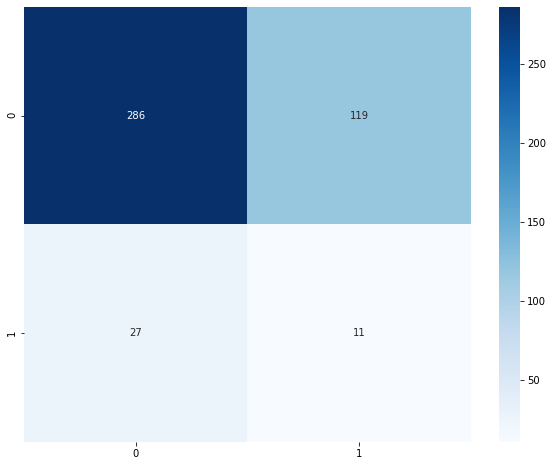


F1 score 0.13095238095238096


In [425]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

0.9142212189616253


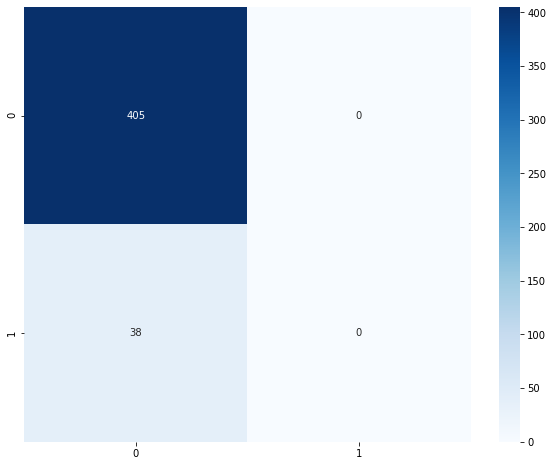


F1 score 0.0


In [426]:
clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

In [427]:
from imblearn.over_sampling import SMOTE, ADASYN

In [527]:
# separar 5% dos dados para teste
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.05, random_state = 42)

# gerar dados sintéticos nos dados de treinamento
X_train_resampled, y_train_resampled = ADASYN().fit_resample(X_train, y_train)

# separar 20% dos dados de treino para validação
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_resampled, y_train_resampled,
                                                              test_size = 0.20, random_state = 42)


Accuracy na validação: 0.6177606177606177


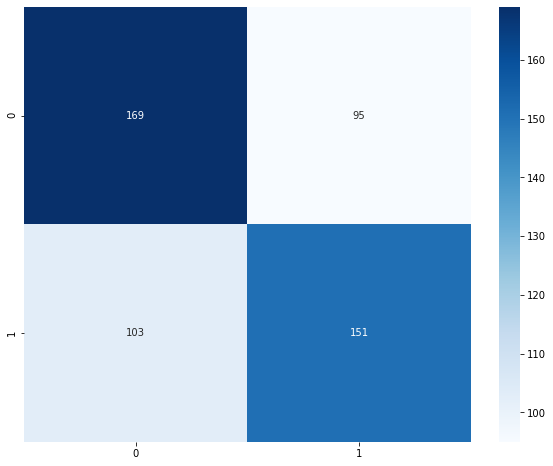


F1 score na validação: 0.604


In [528]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train_final, y_train_final)
y_pred_log = clf.predict(X_val)
print('Accuracy na validação:', clf.score(X_val, y_val))
cf_matrix = confusion_matrix(y_val, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_val, y_pred_log))

Accuracy na validação: 0.9768339768339769


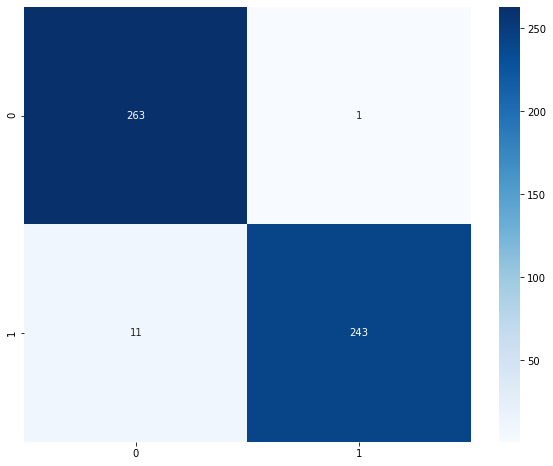


F1 score na validação: 0.9759036144578312


In [529]:
clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train_final, y_train_final)
y_pred_log = clf.predict(X_val)
print('Accuracy na validação:', clf.score(X_val, y_val))
cf_matrix = confusion_matrix(y_val, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_val, y_pred_log))

Accuracy no teste: 0.972972972972973


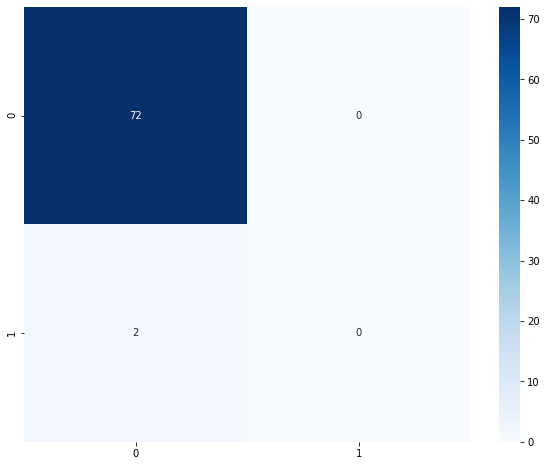


F1 score na validação: 0.0


In [530]:
# scores de teste para o melhor modelo que foi Random Forest

y_pred = clf.predict(X_test)
print('Accuracy no teste:', clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_test, y_pred))

In [531]:
y_test.sum()

2

In [542]:
# voltando nos dados completos, não somente de pacientes com câncer
X = final_df.iloc[:, :812].to_numpy()
X = np.nan_to_num(X, nan = 0)
Y = final_df.iloc[:, 812:].to_numpy()
Y = np.nan_to_num(Y, nan = 0)
y = Y[:, 1]

X_norm = normalize(X, axis = 1)

# separar 5% dos dados para teste
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.05, random_state = 42)

# gerar dados sintéticos nos dados de treinamento
X_train_resampled, y_train_resampled = ADASYN().fit_resample(X_train, y_train)

# separar 20% dos dados de treino para validação
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_resampled, y_train_resampled,
                                                              test_size = 0.20, random_state = 42)

Accuracy na validação: 0.5841248303934871


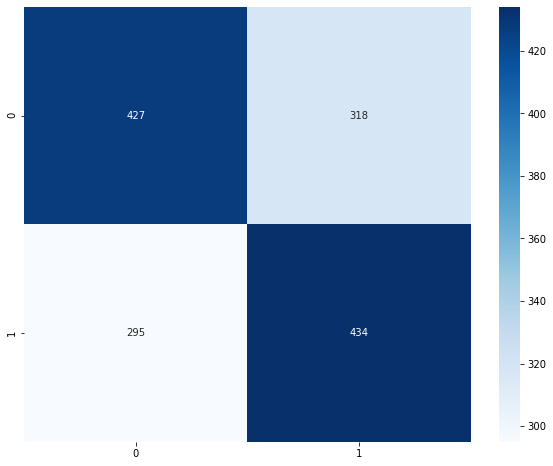


F1 score na validação: 0.5860904794058068


In [543]:
# treino e validação com Logistic Regression

clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train_final, y_train_final)
y_pred_log = clf.predict(X_val)
print('Accuracy na validação:', clf.score(X_val, y_val))
cf_matrix = confusion_matrix(y_val, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_val, y_pred_log))

Accuracy na validação: 0.9776119402985075


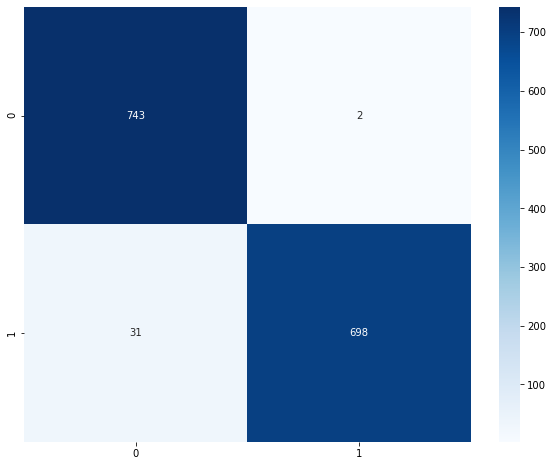


F1 score na validação: 0.9769069279216235


In [544]:
# treino e validação com Random Forest

clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train_final, y_train_final)
y_pred_log = clf.predict(X_val)
print('Accuracy na validação:', clf.score(X_val, y_val))
cf_matrix = confusion_matrix(y_val, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_val, y_pred_log))

Accuracy no teste: 0.9289099526066351


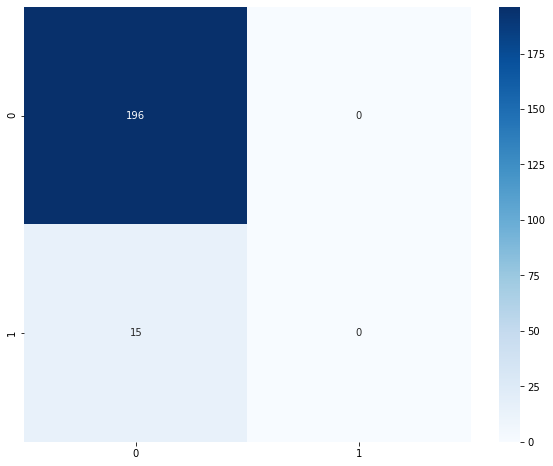


F1 score na validação: 0.0


In [545]:
# scores de teste para o melhor modelo que foi Random Forest

y_pred = clf.predict(X_test)
print('Accuracy no teste:', clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score na validação:', f1_score(y_test, y_pred))

0.9842995169082126


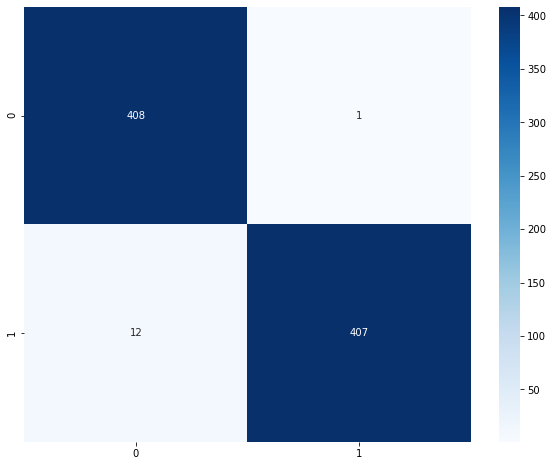


F1 score 0.9842805320435309


In [434]:
clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
cf_matrix = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cf_matrix, annot = True, 
            fmt='0', cmap = 'Blues')
plt.show()

print('\nF1 score', f1_score(y_test, y_pred_log))

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.7291196388261851

In [299]:
important_feat = np.where(clf.coef_ != 0, True, False).tolist()[0]
X = X[:, important_feat]

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)
clf = LogisticRegression(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print(clf.score(X_test, y_test))
print("\n", confusion_matrix(y_test, y_pred_log))
print('\nF1 score', f1_score(y_test, y_pred_log))

0.7291196388261851

 [[313  92]
 [ 28  10]]

F1 score 0.14285714285714285


In [303]:
rforest = RandomForestClassifier(random_state = 42, class_weight = 'balanced_subsample').fit(X_train, y_train)
y_pred_rf = rforest.predict(X_test)
print(rforest.score(X_test, y_test))
print("\n", confusion_matrix(y_test, y_pred_rf))
print('\nF1 score', f1_score(y_test, y_pred_rf))

0.9142212189616253

 [[405   0]
 [ 38   0]]

F1 score 0.0


In [304]:
svm_clf = svm.SVC(random_state = 42, class_weight = 'balanced').fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
svm_clf.score(X_test, y_test)
print(svm_clf.score(X_test, y_test))
print("\n", confusion_matrix(y_test, y_pred_svm))
print('\nF1 score', f1_score(y_test, y_pred_svm))

0.8623024830699775

 [[381  24]
 [ 37   1]]

F1 score 0.031746031746031744
